In [1]:
#Importing all useful libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/anaconda3/envs/pydata/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/envs/pydata/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Read the csv file into a pandas DataFrame

df = pd.read_csv('default of credit card clients.csv', skiprows = 1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
## rename column for easy reference and correct the pay_0 for pay_1
#the analysis assume that PAY_0 is actually pay_1 for the repayment of the month prior to the month where we calculate the defaulting (which is October 2005, in this particular dataset)


df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.rename(index=str, columns={"default payment next month": "default"})
df = df.drop("id", axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'],
      dtype='object')

In [4]:
df.head()
df.dtypes
df.shape
df.isnull().sum()

limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_1        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
bill_amt1    0
bill_amt2    0
bill_amt3    0
bill_amt4    0
bill_amt5    0
bill_amt6    0
pay_amt1     0
pay_amt2     0
pay_amt3     0
pay_amt4     0
pay_amt5     0
pay_amt6     0
default      0
dtype: int64

In [6]:
# Assign X (data) and y (target)
X = df.drop("default", axis=1)
X = X[['limit_bal', 'sex', 'education', 'marriage', 'age']]
y = df["default"]
print(X.shape, y.shape)

(30000, 5) (30000,)


In [7]:
df.corr()


,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
limit_bal,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
sex,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
education,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
marriage,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
age,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
pay_1,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
pay_2,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
pay_3,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
pay_4,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614
pay_5,-0.249411,-0.055064,0.097520,0.035629,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,...,0.271915,0.269783,0.262509,-0.006089,-0.003191,0.009062,-0.058299,-0.033337,-0.023027,0.204149


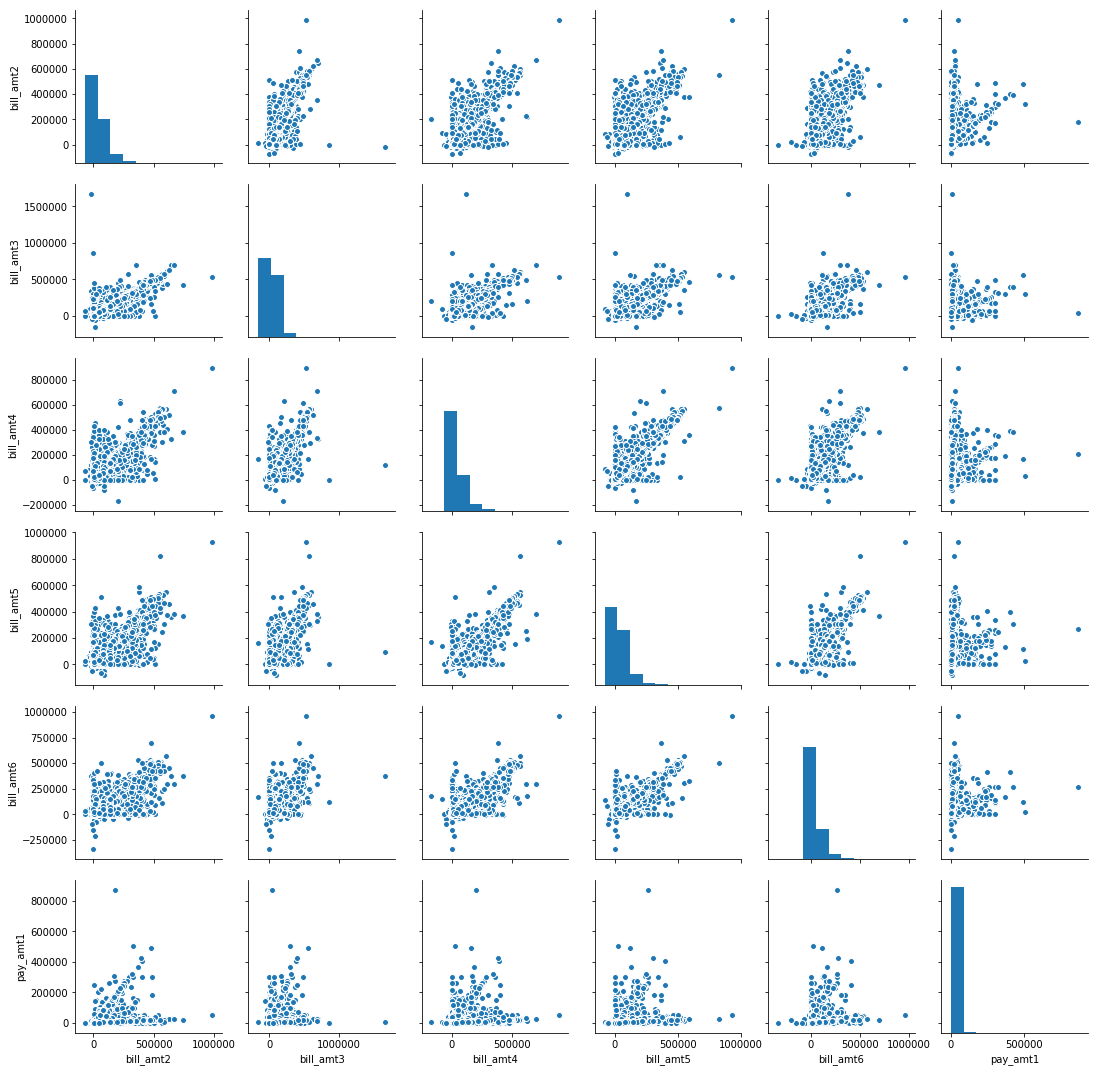

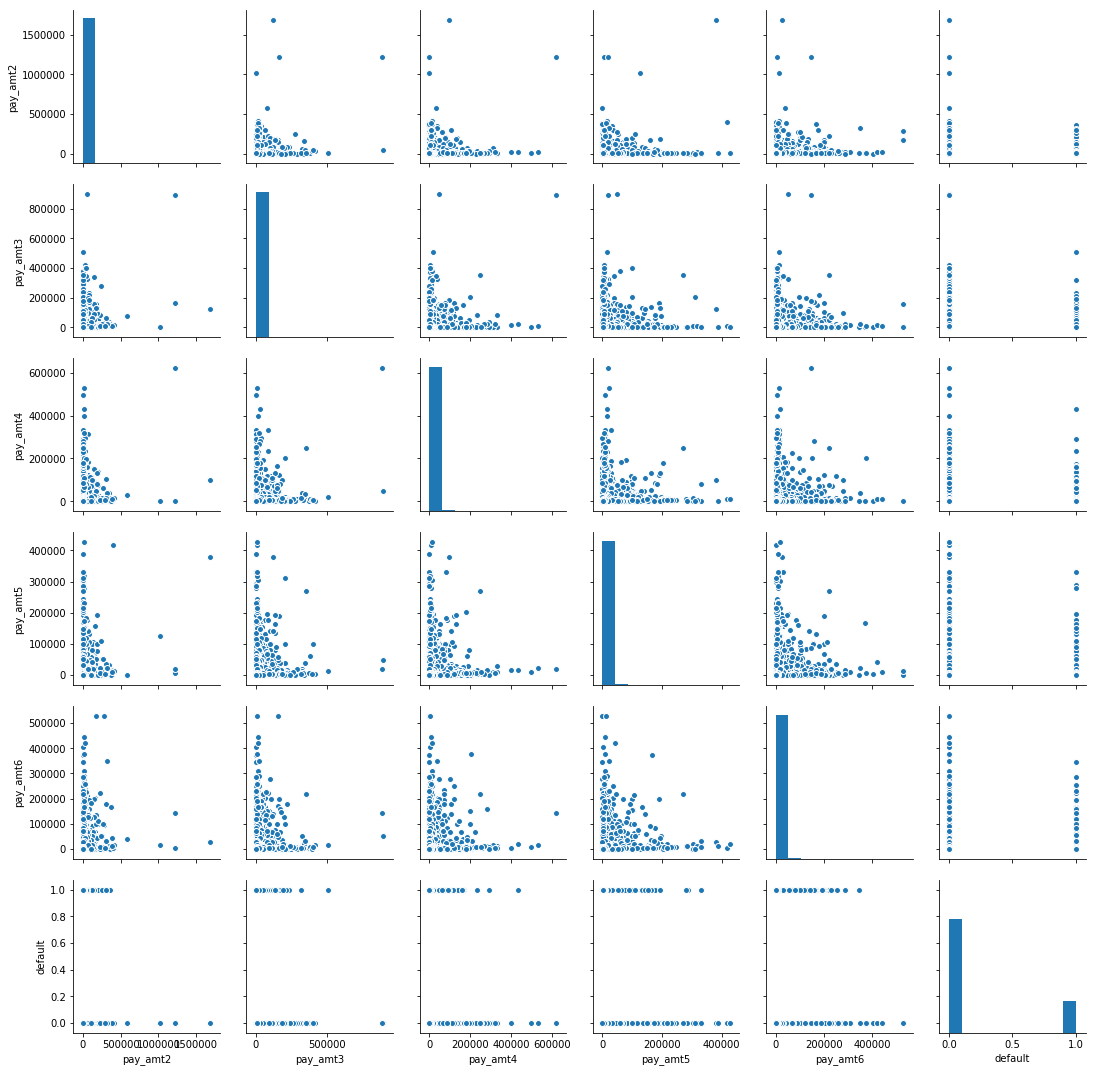

In [8]:
# plot columns with similar names to check the correlation

sns.pairplot(df, vars=df.columns[12:18], kind='scatter')
sns.pairplot(df, vars=df.columns[18:24])

In [9]:
# The plots showed a strong correlation between each other with similar name, which imply a potential multicollinearity problem


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [12]:
target_name = 'default'
X = df.drop('default', axis=1)
X = X[['limit_bal', 'sex', 'education', 'marriage', 'age']]
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [13]:
def CMatrix(CM, labels=['pay','default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [14]:
# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], 
                      columns=['NULL','LogisticReg'])

In [15]:
#the null model

y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

/anaconda3/envs/pydata/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


PREDICTION,pay,default,Total
TRUE,,,
pay,4673,0,4673
default,1327,0,1327
Total,6000,0,6000


In [16]:
#Logistic regression

# 1. Import the estimator object (model)
from sklearn.linear_model import LogisticRegression

# 2. Create an instance of the estimator
logistic_regression = LogisticRegression(n_jobs=-1)

# 3. Use the trainning data to train the estimator
logistic_regression.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

/anaconda3/envs/pydata/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/envs/pydata/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


PREDICTION,pay,default,Total
TRUE,,,
pay,4673,0,4673
default,1327,0,1327
Total,6000,0,6000


In [17]:
#Making prediction

def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    data = robust_scaler.transform(data)
    prob = logistic_regression.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Will default'
    else:
        return 'Will pay'

In [18]:
from collections import OrderedDict
new_customer = OrderedDict([('limit_bal', 4200),('age', 51 ),('sex', 1 ),('education', 3),('marriage', 1 )])

new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

'Will pay'

In [19]:
#Kmeans clustering methofds

In [20]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  

In [21]:
# Read the csv file into a pandas DataFrame

df = pd.read_csv('default of credit card clients.csv', skiprows = 1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [22]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.rename(index=str, columns={"default payment next month": "default"})
df = df.drop("id", axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'],
      dtype='object')

In [23]:
# Assign X (data) and y (target)
X = df.drop("default", axis=1)
X = X[['limit_bal', 'sex', 'education', 'marriage', 'age']]
y = df["default"]
print(X.shape, y.shape)

(30000, 5) (30000,)


In [24]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  

In [25]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

In [26]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=2)  
classifier.fit(X_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [27]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [28]:
y_pred = classifier.predict(X_test)

In [29]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  


[[4257  430]
 [1133  180]]
             precision    recall  f1-score   support

          0       0.79      0.91      0.84      4687
          1       0.30      0.14      0.19      1313

avg / total       0.68      0.74      0.70      6000



In [30]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0,0.5,'Mean Error')

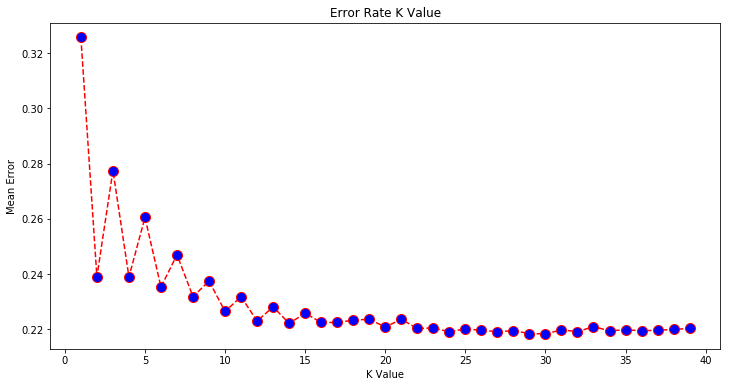

In [31]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

In [32]:
#From the output we can see that the mean error is zero when the value of the K is after 5. so we play
# around with the value of K to see how it impacts the accuracy of the predictions.


In [33]:
# K = 7
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=7)  
classifier.fit(X_train, y_train)  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [34]:
y_pred = classifier.predict(X_test)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  


[[4376  311]
 [1171  142]]
             precision    recall  f1-score   support

          0       0.79      0.93      0.86      4687
          1       0.31      0.11      0.16      1313

avg / total       0.68      0.75      0.70      6000



In [36]:
# K = 8
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=8)  
classifier.fit(X_train, y_train)  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

In [37]:
y_pred = classifier.predict(X_test)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  


[[4540  147]
 [1244   69]]
             precision    recall  f1-score   support

          0       0.78      0.97      0.87      4687
          1       0.32      0.05      0.09      1313

avg / total       0.68      0.77      0.70      6000



In [39]:
# K = 10
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=10)  
classifier.fit(X_train, y_train)  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [40]:
y_pred = classifier.predict(X_test)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  


[[4576  111]
 [1248   65]]
             precision    recall  f1-score   support

          0       0.79      0.98      0.87      4687
          1       0.37      0.05      0.09      1313

avg / total       0.69      0.77      0.70      6000

